## CuLSH

In [1]:
#!pip install pycuda
#https://pypi.org/project/pycuda/
#https://documen.tician.de/pycuda/
#https://stackoverflow.com/questions/68256354/cuda-c-library-in-python-transfer-gpu-memory-data-from-one-functions-to-ower
#https://forums.developer.nvidia.com/t/fast-memcpy-micro-benchmarking-cuda-python-wrapper-multi-gpu-seg-fault/274712

In [2]:
# backup
#https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_Deep_Supervised_Hashing_CVPR_2016_paper.pdf
#https://github.com/thuml/HashNet/tree/master
#https://github.com/flyingpot/pytorch_deephash
#https://github.com/weixu000/DSH-pytorch/blob/master/utils.py
#https://github.com/swuxyj/DeepHash-pytorch?tab=readme-ov-file
#https://github.com/dansuh17/deep-supervised-hashing
#https://github.com/inducer/pycuda/blob/main/examples/demo_elementwise.py

In [3]:
#Hash on gpu
#https://docs.rapids.ai/api/libcudf/stable/group__nvtext__minhash


#https://on-demand.gputechconf.com/gtc/2015/presentation/S5796-Peter-Andreas-Entschev.pdf
#https://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html
#http://www.phash.org/


In [4]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy

from pycuda.compiler import SourceModule
mod = SourceModule("""
__global__ void multiply_them(float *dest, float *a, float *b)
{
  const int i = threadIdx.x;
  dest[i] = a[i] * b[i];
}
""")

multiply_them = mod.get_function("multiply_them")

a = numpy.random.randn(20).astype(numpy.float32)
b = numpy.random.randn(20).astype(numpy.float32)


print(a)
print(b)
dest = numpy.zeros_like(a)
multiply_them(
        drv.Out(dest), drv.In(a), drv.In(b),
        block=(400,1,1), grid=(1,1))

print(dest-a*b)

[ 2.1087716   2.2914555   1.7716545  -1.3177116  -0.07604671 -0.7493813
 -0.17168829  0.47271165  0.19768478 -0.38715538  1.1830893   1.7740462
  0.09638056  1.1157436   0.57610524  0.16591892 -0.06123103  1.0992761
  0.5507163   0.2769248 ]
[ 6.1166215e-01  8.9619738e-01  5.1631701e-01 -3.4198734e-01
  1.3006571e-01  2.9976800e-01 -1.6022705e+00  3.2449493e-01
  1.4077414e+00 -1.4777108e-01  9.9262345e-01  2.7718478e-01
 -1.2706857e+00  8.6036968e-01 -4.6936586e-01 -1.0339336e+00
  2.0692515e+00 -3.9774367e-01 -6.5031040e-01 -1.6411948e-03]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### 1. Load Cifar

In [5]:
import os
import _pickle as cPickle
import numpy as np

PATH = "../data/cifar-10-batches-py/"

In [6]:
def load_batch():
    file = 'data_batch_1'

    f = open(PATH+file, 'rb')
    dict_ = cPickle.load(f, encoding='latin1')
    images = dict_['data']
    #images = np.reshape(images, (10000, 3, 32, 32))
    labels = dict_['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

In [7]:
def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

def print_classes(label_names):
    for i in range(0, 10):
        print(str(i) + " : " + label_names[i] + "  ")

label_names = load_classes()
print_classes(label_names)

0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  


In [8]:
images, labels = load_batch()

In [9]:
special_image = images[0]

In [10]:
special_image2 = special_image
special_image = np.reshape(special_image, (3, 32, 32)).T

In [11]:
special_image.shape

(32, 32, 3)

### 1.2 Load ImageNet

In [12]:
#https://patrykchrabaszcz.github.io/Imagenet32/
# 1 281 167 training images from 1000 classes and 50 000 validation images with 50 images per class.

In [13]:
!pip install git+https://github.com/nottombrown/imagenet_stubs

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-hddz2671
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-hddz2671
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done


In [14]:
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name
print(label_to_name(0))

tench, Tinca tinca


In [15]:
IMAGENET_PATH = "../data/Imagenet32_train/"

In [16]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [17]:
def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    dict_ = unpickle(data_file + str(idx))

    images = dict_['data']
    labels = dict_['labels']

    ## images_without_mean = dict_['mean']   ??? check is there are better results or not

    return images, labels

In [18]:
images2, labels2 = load_databatch(IMAGENET_PATH, 1)

In [19]:
images2.shape

(128116, 3072)

In [20]:
len(labels2)

128116

In [21]:
HN_example_image = np.reshape(images2[1], (3, 32, 32)).T

In [22]:
HN_exmaple_label = label_to_name(labels2[1])

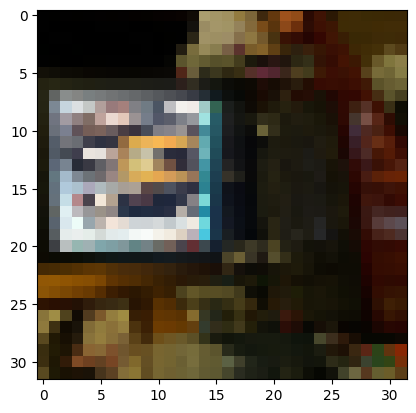

In [23]:
from matplotlib import pyplot as plt
plt.imshow(HN_example_image, interpolation='nearest')
plt.show()

In [24]:
HN_exmaple_label

'espresso maker'

### 2. Preprocesing 

In [25]:
def scale_image_down_and_gray_1d(image, new_rows, new_cols):

    pixels = 1024
    newPixels = new_rows * new_cols;
    factor = pixels / newPixels;

    new_image = np.empty(newPixels, dtype=numpy.uint8)

    for idx in range(newPixels):
        pixelToTake = int(idx*factor)
        
        pixel = 0.2989 * image[pixelToTake] \
              + 0.5870 * image[1024+pixelToTake] \
              + 0.1140 * image[2048+pixelToTake]
        
        new_image[idx] = pixel
        
    return new_image

In [26]:
def scale_image_down_and_gray(np_image, new_rows, new_columns):
    
    columns = np_image.shape[0]
    rows = np_image.shape[1]

    factor_columns = columns / new_columns
    factor_rows = rows / new_rows

    new_image = np.empty([new_columns, new_rows, 1], dtype=numpy.uint8)

    print(new_image.shape)
    
    for row in range(new_rows):
        for col in range(new_columns):
            new_row = int(row * factor_rows)
            new_col = int(col * factor_columns)

            pixel = 0.2989 * np_image[new_col][new_row][0] \
                  + 0.5870 * np_image[new_col][new_row][1] \
                  + 0.1140 * np_image[new_col][new_row][2]
            
            new_image[col][row][0] = pixel
    return new_image

def scale_image_up(np_image, new_width, new_height):
    pass

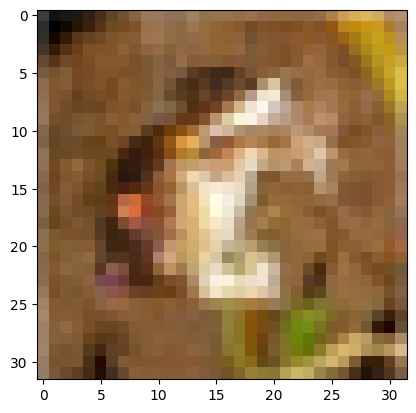

In [27]:
from matplotlib import pyplot as plt
plt.imshow(special_image, interpolation='nearest')
plt.show()

In [28]:
down_scaled_image = scale_image_down_and_gray(special_image, 9, 8)

(8, 9, 1)


In [29]:
down_scaled_image.shape

(8, 9, 1)

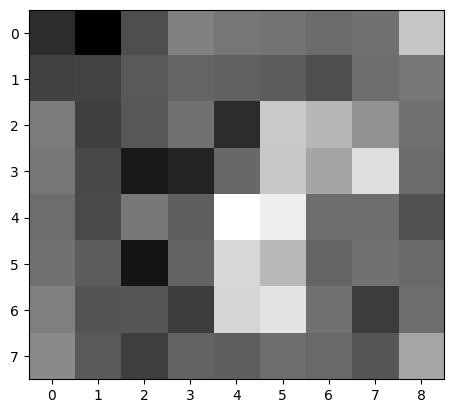

In [30]:
plt.imshow(down_scaled_image, cmap='gray')
plt.show()

In [31]:
down_scaled_image.shape

(8, 9, 1)

In [32]:
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

### own kernel to image

In [33]:
# article - https://medium.com/@sim30217/bilinear-interpolation-e41fc8b63fb4
# Nearest Neighbor - which can result in visible artifacts or jagged edges.
# Billinar 
# Gaussian - https://medium.com/@rohit-krishna/coding-gaussian-blur-operation-from-scratch-in-python-f5a9af0a0c0f
# SPline ??? or other common kernel 
#http://forum.doom9.org/archive/index.php/t-145210.html

### Create Hash

In [34]:
down_scaled_image.shape

(8, 9, 1)

In [35]:
def comp_difference(image_2d):
    sequence = ""

    rows = image_2d.shape[0]
    cols = image_2d.shape[1]

    print( rows, cols)
    for row in range(rows):
        for col in range(1, cols):
            if image_2d[row][col-1] < image_2d[row][col]:
                sequence += '1'
            else:
                sequence += '0'

    print(sequence)

In [36]:
comp_difference(down_scaled_image) # 63E3683A50325929

8 9
0110001111100011011010000011101001010000001100100101100100101001


In [37]:
diff = down_scaled_image[:, 1:] > down_scaled_image[:, :-1] # 63E3683A50325929

In [38]:
print(diff.flatten().astype(int))

[0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0
 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1]


#### GPU-kernel convertion

In [39]:
#https://stackoverflow.com/questions/5029920/how-to-use-2d-arrays-in-cuda
#https://github.com/royinx/CUDA_Resize

In [40]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy

from pycuda.compiler import SourceModule

In [41]:
'''
mod = SourceModule("""
__global__ void ResizeAndGrayOneImage2D(float imageR[32][32], float hash[9][9], int rows, int columns, int new_rows, int new_cols)
{
    int row = blockDim.y * blockIdx.y + threadIdx.y;
    int col = blockDim.x * blockIdx.x + threadIdx.x;
    
    if( row >= new_rows || col >= new_cols ) return;

    float factor_columns = columns / new_cols;
    float factor_rows = rows / new_rows;

    int new_row = row * factor_rows;
    int new_col = col * factor_columns;

    auto pixel = 0.2989 * imageR[new_col][new_row] + 0.5870 * imageR[new_col][new_row] + 0.1140 * imageR[new_col][new_row];
               
    hash[col][row] = pixel;
}

""")

your_kernel_2D = mod.get_function("ResizeAndGrayOneImage2D")

'''

'\nmod = SourceModule("""\n__global__ void ResizeAndGrayOneImage2D(float imageR[32][32], float hash[9][9], int rows, int columns, int new_rows, int new_cols)\n{\n    int row = blockDim.y * blockIdx.y + threadIdx.y;\n    int col = blockDim.x * blockIdx.x + threadIdx.x;\n    \n    if( row >= new_rows || col >= new_cols ) return;\n\n    float factor_columns = columns / new_cols;\n    float factor_rows = rows / new_rows;\n\n    int new_row = row * factor_rows;\n    int new_col = col * factor_columns;\n\n    auto pixel = 0.2989 * imageR[new_col][new_row] + 0.5870 * imageR[new_col][new_row] + 0.1140 * imageR[new_col][new_row];\n               \n    hash[col][row] = pixel;\n}\n\n""")\n\nyour_kernel_2D = mod.get_function("ResizeAndGrayOneImage2D")\n\n'

In [42]:
### PyCUDA error - working properly only for floats
### LogicError - not know why, po prostu tak sobie wyskoczył

mod = SourceModule("""

__global__ void ResizeAndGrayOneImage(float* image, float* hash, int pixels, int new_rows, int new_cols)
{
    extern __shared__ int pixelsValues[72];

    int idx         = threadIdx.x + blockIdx.x * blockDim.x;
    float newPixels = new_rows * new_cols;
    
    if (idx >= newPixels) return;

    float factor           = pixels / newPixels;
    const auto pixelToTake = (int)(idx*factor);


    auto pixel = 0.2989 * image[pixelToTake] + 0.5870 * image[1024+pixelToTake] + 0.1140 * image[2048+pixelToTake];

    pixelsValues[idx] = pixel;

    __syncthreads();
    
    if(idx == 0) return;

    pixelsValues[idx-1] < pixelsValues[idx] ? hash[idx-1] = 1 : hash[idx-1] = 0;    
}

""")

your_kernel = mod.get_function("ResizeAndGrayOneImage")

In [43]:
mod = SourceModule("""

__global__ void ResizeAndGray1000Images(float* image, float* hash, int pixels, int new_rows, int new_cols, int amountOfImages)
{

    int idx         = threadIdx.x + blockIdx.x * blockDim.x;
    float newPixels = new_rows * new_cols;
    int pixelsValues[72];
    
    if (idx > amountOfImages) return;

    float factor      = pixels / newPixels;
    int imageStartIdx = 3072*idx;
    
    for( int i=0; i<newPixels; i++ )
    {
        const auto pixelToTake = (int)(imageStartIdx+i*factor);
        auto pixel = 0.2989 * image[pixelToTake] + 0.5870 * image[1024+pixelToTake] + 0.1140 * image[2048+pixelToTake];
        pixelsValues[i] = pixel;
    }
    for( int i=1; i<newPixels; i++ )
    {
        pixelsValues[i-1] < pixelsValues[i] ? hash[72*idx+i-1] = 1 : hash[72*idx+i-1] = 0;
    }
}

""")

your_kernel_1000_images = mod.get_function("ResizeAndGray1000Images")

In [44]:
def arrayToHexString(imageHashArray):
    hash_ = ""

    tmp_imageHashArray = imageHashArray.astype(numpy.uint8)

    
    for i in range(0, imageHashArray.shape[0], 4):
        tmp = str(tmp_imageHashArray[i]) + str(tmp_imageHashArray[i+1]) + str(tmp_imageHashArray[i+2]) + str(tmp_imageHashArray[i+3])
        
        hash_ += hex(int(tmp, 2))[2:]

    return hash_

In [45]:
special_image2.shape

(3072,)

In [46]:
b = numpy.zeros(72).astype(numpy.float32)
b.dtype

dtype('float32')

In [47]:
# max threads = 1024
# max blocks = 65535

your_kernel(drv.In(special_image2.astype(numpy.float32)), drv.Out(b), np.int32(1024) , np.int32(8) , np.int32(9), 
            block=(72,1,1))

In [48]:
arrayToHexString(b) # 63E3683A50325929

'dd599776ab5126b2b4'

In [49]:
other_image = scale_image_down_and_gray_1d(special_image2, 9, 8)

In [50]:
other_image_reshaped = np.reshape(other_image, (8, 9))
other_image_reshaped

array([[ 61, 111, 135,  76,  86,  89, 101,  71,  84],
       [ 36,  86,  73,  88, 107,  83,  56, 104, 146],
       [107,  32,  95,  65,  70, 107, 140, 103, 107],
       [119, 176, 101, 117, 126,  75, 210, 108, 249],
       [121, 193, 120, 151, 205, 159, 195,  99, 119],
       [111,  94,  92, 141, 115, 104, 111, 106, 101],
       [115, 169,  94, 128, 112, 113, 118, 114, 103],
       [182,  97, 157, 102, 108, 135,  93, 151, 123]], dtype=uint8)

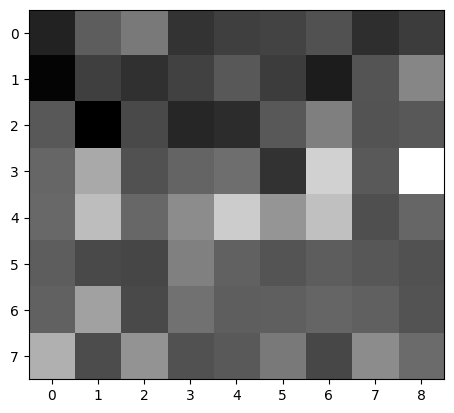

In [51]:
plt.imshow(other_image_reshaped, cmap='gray')
plt.show()

In [52]:
#comp_difference() # 63E3683A50325929

In [53]:
special_image3 = special_image2[:1024]

In [54]:
special_image3.shape

(1024,)

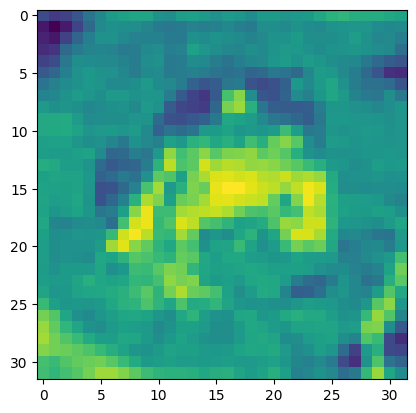

In [55]:
plt.imshow(np.reshape(special_image3, (32, 32)))
plt.show()

### 2D

In [56]:
in_image = special_image2.reshape([3,32,32]).astype(numpy.float32).T
in_image.shape
in_image[:,:,0].shape

(32, 32)

In [57]:
out_image = numpy.zeros([8,9]).astype(numpy.float32)
out_image.shape

(8, 9)

In [66]:
# max threads = 1024
# max blocks = 65535

your_kernel_2D(drv.In(in_image[:,:,0]), drv.Out(out_image), np.int32(32), np.int32(32) , np.int32(8) , np.int32(9), 
            block=(8,9,1), grid=(1,1))

#np.set_printoptions(suppress = False)
#out_image_res = np.reshape(out_image, (8, 9))
#out_image_res.shape

NameError: name 'your_kernel_2D' is not defined

In [67]:
plt.imshow(out_image_res, cmap='gray')
plt.show()

NameError: name 'out_image_res' is not defined

### CuLSH

In [60]:
#your_kernel(drv.In(special_image2.astype(numpy.float32)), drv.Out(b), np.int32(1024) , np.int32(8) , np.int32(9), 
#           block=(72,1,1))

In [61]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0;
        signature = numpy.zeros(72).astype(numpy.float32)
        for image in images:
            your_kernel(drv.In(image), drv.Out(signature), np.int32(1024) , np.int32(8) , np.int32(9), 
            block=(72,1,1))
            signature_ = signature.astype(numpy.bool_)
            # Keep track of each image's signature
            self.signatures[idx] = np.packbits(signature_)
            self.fill_buckets(signature_, idx)
            idx+=1

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates
            
    

In [62]:
images = images.astype(numpy.float32)
images.shape

(10000, 3072)

In [64]:
import time

start = time.time()

lsh = LSH(8, 8)
lsh.compute_hash(images)
#pairs = lsh.compute_candidate()
#duplicates = lsh.check_candidate(pairs,0.9)

end = time.time()

In [65]:
print( "time: ", end - start )

time:  1.7985785007476807


In [86]:
len(duplicates)

1147

In [88]:
duplicates

[(661, 2210, 1.0),
 (1199, 5500, 1.0),
 (1335, 9786, 1.0),
 (8443, 9786, 1.0),
 (4875, 9275, 1.0),
 (1335, 8443, 1.0),
 (1815, 5500, 0.984375),
 (2307, 5333, 0.984375),
 (3812, 9786, 0.984375),
 (9206, 9786, 0.984375),
 (1335, 9206, 0.984375),
 (8443, 9206, 0.984375),
 (1335, 3812, 0.984375),
 (1199, 1815, 0.984375),
 (3812, 8443, 0.984375),
 (8975, 9432, 0.96875),
 (8601, 9786, 0.96875),
 (1335, 1461, 0.96875),
 (1815, 4628, 0.96875),
 (1711, 9786, 0.96875),
 (1335, 5756, 0.96875),
 (1199, 1557, 0.96875),
 (5915, 8443, 0.96875),
 (1461, 8443, 0.96875),
 (2307, 5500, 0.96875),
 (5756, 8443, 0.96875),
 (1335, 5915, 0.96875),
 (1711, 8601, 0.96875),
 (1557, 5500, 0.96875),
 (2254, 9786, 0.96875),
 (1335, 2254, 0.96875),
 (1335, 8601, 0.96875),
 (8443, 8601, 0.96875),
 (2145, 9064, 0.96875),
 (3595, 6787, 0.96875),
 (1711, 8443, 0.96875),
 (1815, 6368, 0.96875),
 (1199, 2307, 0.96875),
 (5915, 9786, 0.96875),
 (2254, 8443, 0.96875),
 (1461, 9786, 0.96875),
 (1335, 1711, 0.96875),
 (3812, 

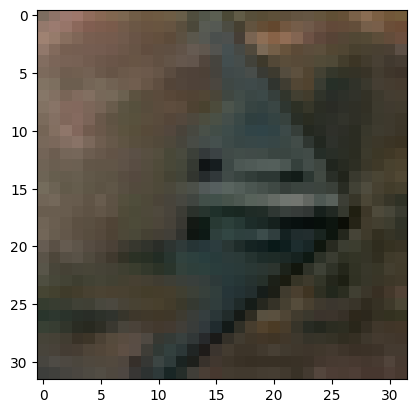

In [93]:
plt.imshow(images[626].reshape(3,32,32).T.astype(numpy.uint8), interpolation='nearest')
plt.show()

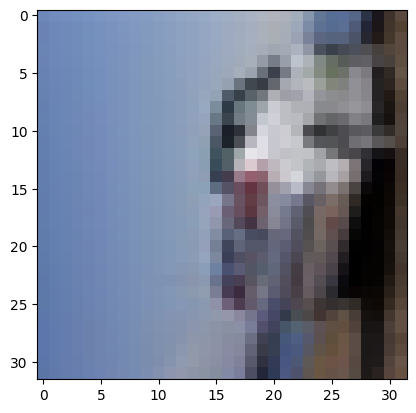

In [94]:
plt.imshow(images[6899].reshape(3,32,32).T.astype(numpy.uint8), interpolation='nearest')
plt.show()

In [131]:
images1000 = images[:1000].astype(numpy.float32).reshape(3072000)
images1000.shape

(3072000,)

In [132]:
hash1000 = numpy.zeros([72000]).astype(numpy.float32)
hash1000.shape

(72000,)

In [183]:
special_image2 = images[0]
special_image2.shape

(3072,)

In [184]:
start = time.time()

for i in range(1000):
    your_kernel(drv.In(special_image2.astype(numpy.float32)), drv.Out(b), np.int32(1024) , np.int32(8) , np.int32(9), 
            block=(72,1,1))

end = time.time()
print( "time: ", end - start )

time:  0.25856804847717285


In [185]:
arrayToHexString(b) 

'dd599776ab5126b2b4'

In [180]:
start = time.time()

your_kernel_1000_images(drv.In(images1000), drv.Out(hash1000), np.int32(1024) , np.int32(8) , np.int32(9), np.int32(1000),
            block=(1001,1,1))

end = time.time()
print( "time: ", end - start )

time:  0.004638195037841797


In [181]:
hash1000[71928:72000]

array([0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0.], dtype=float32)

In [187]:
arrayToHexString(hash1000[0:64]) 

'dd599776ab5126b2'

In [ ]:
##